## Hardware Platform Characterization

In [1]:
CPUDescription="Mid-2017 MacBook Pro laptop with an Intel Core i7-7920HQ processor"
MemoryDescription="LPDDR3-2133"
print (CPUDescription)
print (MemoryDescription)

Mid-2017 MacBook Pro laptop with an Intel Core i7-7920HQ processor
LPDDR3-2133


### Processor Characteristics
Processor Frequency [GHz]<br/> 
Processor Cores<br/> 
Hyperthreads<br/> 
Vector Width [bits]<br/> 
Word Size in Bits [64 for double, 32 for single precision]<br/> 
FMA [2 for Fused Multiple Add, 1 otherwise] 

In [2]:
ProcessorFrequency=3.7
ProcessorCores=4
Hyperthreads=2
VectorWidth=256
WordSizeBits=64
FMA=2

### Main Memory Characteristics
Data Transfer Rate [MT/s]<br/>
Bytes Transferred per Access [Bytes]<br/>
Number Channels<br/>

In [3]:
DataTransferRate=2133
MemoryChannels=2
BytesTransferredPerAccess=8

In [4]:
TheoreticalMaximumFlops=ProcessorCores*Hyperthreads*ProcessorFrequency*VectorWidth/WordSizeBits*FMA
print ("Theoretical Maximum Flops =",TheoreticalMaximumFlops, "GFLOPS/s")

Theoretical Maximum Flops = 236.8 GFLOPS/s


In [5]:
TheoreticalMemoryBandwidth=DataTransferRate*MemoryChannels*BytesTransferredPerAccess/1000
print ("Theoretical Maximum Bandwidth (at main memory) =", TheoreticalMemoryBandwidth, "GiB/s")

Theoretical Maximum Bandwidth (at main memory) = 34.128 GiB/s


In [6]:
WordSizeBytes=WordSizeBits/8
TheoreticalMachineBalance=TheoreticalMaximumFlops/TheoreticalMemoryBandwidth
print ("Theoretical Machine Balance = ",TheoreticalMachineBalance, "Flops/byte")
print ("Theoretical Machine Balance = ",TheoreticalMachineBalance*WordSizeBytes, "Flops/word")

Theoretical Machine Balance =  6.938584153774028 Flops/byte
Theoretical Machine Balance =  55.50867323019222 Flops/word


In [7]:
smemroofs = [21000.0, 9961.16, 1171.55, 224.08]
scomproofs = [2801.24, 1400.26]
smem_roof_name = ["L1 Bandwidth", "L2 Bandwidth", "L3 Bandwidth", "DRAM Bandwidth"]
scomp_roof_name = ["DP Vector FMA Peak", "DP Vector Add Peak"]
AI = [.3608, .2106]
FLOPS = [41.3, 2.735]
labels = ["CloverLeaf w/OpenMP and Vectorization", "CloverLeaf Serial"]

print ('memroofs', smemroofs)
print ('mem_roof_names', smem_roof_name)
print ('comproofs', scomproofs)
print ('comp_roof_names', scomp_roof_name)
print ('AI', AI)
print ('FLOPS', FLOPS)
print ('labels', labels)

memroofs [21000.0, 9961.16, 1171.55, 224.08]
mem_roof_names ['L1 Bandwidth', 'L2 Bandwidth', 'L3 Bandwidth', 'DRAM Bandwidth']
comproofs [2801.24, 1400.26]
comp_roof_names ['DP Vector FMA Peak', 'DP Vector Add Peak']
AI [0.3608, 0.2106]
FLOPS [41.3, 2.735]
labels ['CloverLeaf w/OpenMP and Vectorization', 'CloverLeaf Serial']


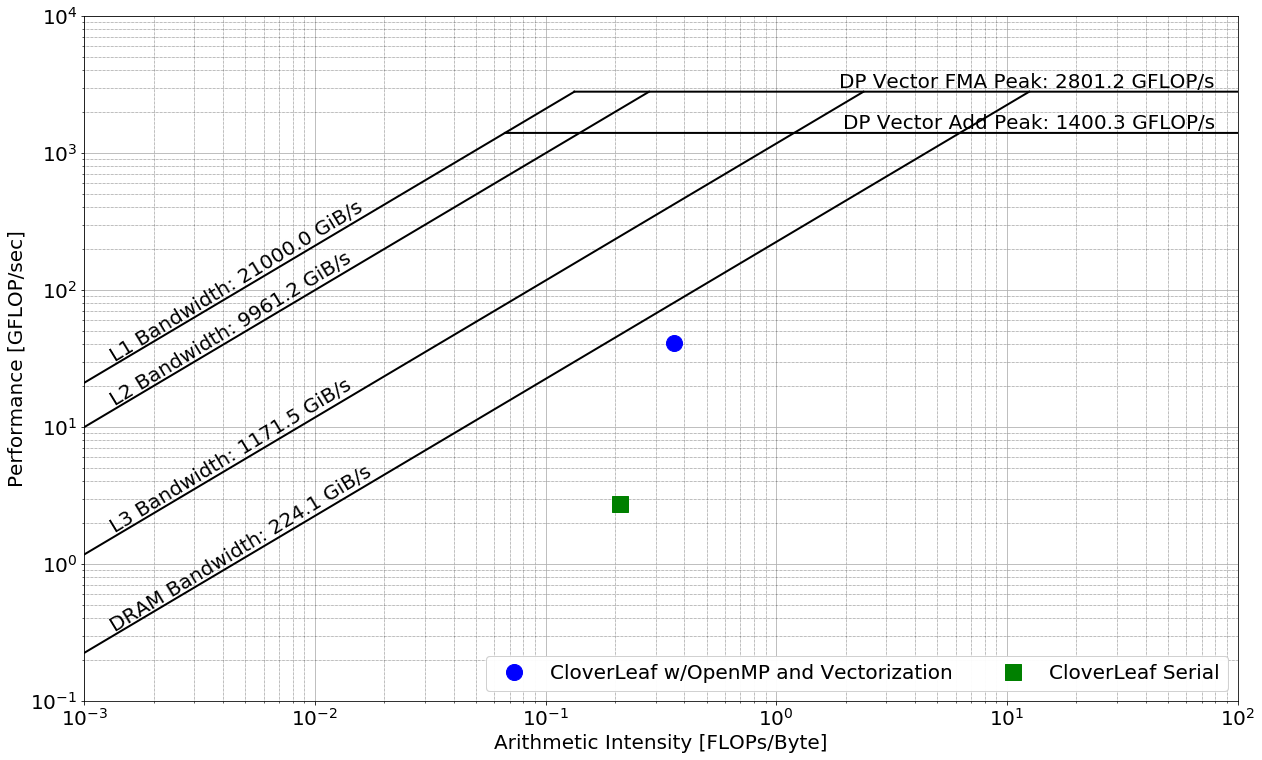

In [8]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

font = { 'size'   : 20}
plt.rc('font', **font)

markersize = 16
colors = ['b','g','r','y','m','c']
styles = ['o','s','v','^','D',">","<","*","h","H","+","1","2","3","4","8","p","d","|","_",".",","]

fig = plt.figure(1,figsize=(20.67,12.6))
plt.clf()
ax = fig.gca()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Arithmetic Intensity [FLOPs/Byte]')
ax.set_ylabel('Performance [GFLOP/sec]')
ax.grid()
ax.grid(which='minor', linestyle=':', linewidth=0.5, color='black')

nx = 10000
xmin = -3
xmax = 2
ymin = 0.1
ymax = 10000

ax.set_xlim(10**xmin, 10**xmax)
ax.set_ylim(ymin, ymax)

ixx = int(nx*0.02)
xlim = ax.get_xlim()
ylim = ax.get_ylim()

scomp_x_elbow = [] 
scomp_ix_elbow = [] 
smem_x_elbow = [] 
smem_ix_elbow = [] 

x = np.logspace(xmin,xmax,nx)
for roof in scomproofs:
    for ix in range(1,nx):
        if smemroofs[0] * x[ix] >= roof and smemroofs[0] * x[ix-1] < roof:
            scomp_x_elbow.append(x[ix-1])
            scomp_ix_elbow.append(ix-1)
            break


for roof in smemroofs:
    for ix in range(1,nx):
        if (scomproofs[0] <= roof * x[ix] and scomproofs[0] > roof * x[ix-1]):
            smem_x_elbow.append(x[ix-1])
            smem_ix_elbow.append(ix-1)
            break        

for i in range(0,len(scomproofs)):
    y = np.ones(len(x)) * scomproofs[i]  
    ax.plot(x[scomp_ix_elbow[i]:],y[scomp_ix_elbow[i]:],c='k',ls='-',lw='2')

for i in range(0,len(smemroofs)):
    y = x * smemroofs[i]  
    ax.plot(x[:smem_ix_elbow[i]+1],y[:smem_ix_elbow[i]+1],c='k',ls='-',lw='2')


marker_handles = list()
for i in range(0,len(AI)):
  ax.plot(float(AI[i]),float(FLOPS[i]),c=colors[i],marker=styles[i],linestyle='None',ms=markersize,label=labels[i])
  marker_handles.append(ax.plot([],[],c=colors[i],marker=styles[i],linestyle='None',ms=markersize,label=labels[i])[0]) 

for roof in scomproofs:
    ax.text(x[-ixx],roof,
            scomp_roof_name[scomproofs.index(roof)] + ': ' + '{0:.1f}'.format(float(roof)) + ' GFLOP/s',
            horizontalalignment='right',
            verticalalignment='bottom')

for roof in smemroofs:
    ang = np.arctan(np.log10(xlim[1]/xlim[0]) / np.log10(ylim[1]/ylim[0]) 
                                 * fig.get_size_inches()[1]/fig.get_size_inches()[0] )
    ax.text(x[ixx],x[ixx]*roof*(1+0.25*np.sin(ang)**2),
            smem_roof_name[smemroofs.index(roof)] + ': ' + '{0:.1f}'.format(float(roof)) + ' GiB/s',
            horizontalalignment='left',
            verticalalignment='bottom',
            rotation=180/np.pi*ang)


leg1 = plt.legend(handles = marker_handles,loc=4, ncol=2)
ax.add_artist(leg1)

plt.savefig('roofline.png')
plt.savefig('roofline.eps')
plt.savefig('roofline.pdf')
plt.savefig('roofline.svg')

plt.show()